## Linear Correlations and Statistical Significance.

[Last lesson](http://nbviewer.jupyter.org/github/willyhagi/climate-statistics/blob/master/Jupyter-Notebooks/autocorrel.ipynb#Autocorrelation-Function-and-Correlogram.)
was focused on what Autocorrelation means and, at the end, we had a glimpse on how it could be used to defined in a context of Hypothesis Testing and Statistical Significance. It will be assumed, from now on, that you have at least some familiarity with these concepts. 

The work of Chen (1982) and Livezey and Chen (1983) famously presented, based on a modified verson of what was proposed by Davies (1976), a method to assess the Statistical Significance of some correlations they made. Later, this was adressed by Thiébaux and Zwiers (1984) and some others until it was completely bashed by von Storch and Navarra (1999). 

They claimed one could estimate the effective number of degrees of freedom through the autoregressive properties of both the variables used to make the correlations (check their Equations 1 and 2). However, their critics argued later that this method was neither reliable nor conceptually sound enough.   

All of this to say that the method we saw last lesson has basically the same spirit of the Livezey-Chen method and to warn you that there are many other methods, using Monte Carlo tests and fancy things, to estimate the quantities we saw above. Can't say no one told you now.

Enough of polemics, let's see how to make some linear correlations with Python! 

In [1]:
import cartopy.crs          as ccrs
import cartopy.feature      as cf
import cartopy              as cartopy
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as gridspec
import numpy                as np
import xarray               as xr
import scipy

from cartopy.mpl.ticker    import LongitudeFormatter, LatitudeFormatter
from scipy.signal          import detrend
from cartopy.util          import add_cyclic_point
from functions             import*

In [3]:
dset  =  xr.open_dataset('pacific_asst_1951_2015.nc')
sst   =  dset['sst'][:,:,:]
lat   =  dset['lat'][:]
lon   =  dset['lon'][:]

lon  =  np.asarray(lon.lon.values)
lat  =  np.asarray(lat.lat.values)


nino3 = np.loadtxt('nino3.asc')

Both datasets above I got using the annual cycle script, which you must be tired to see by now.

It's useful to detrend your data before the correlations, but unfortunaly this is a very awkward task to do with SciPy until now. The following lines of code are just a Class(y) way to do what [Dr. Nicolas Fauchereau did right here to detrend his data](http://nicolasfauchereau.github.io/climatecode/posts/eof-analysis-with-scikit-learn/). You are very much encouraged to read his notebook at this point.

The dimensions of our dataset are:

In [4]:
print (sst.shape)

(780, 31, 96)


That is, 780 months of data from 1981-2010 for the Tropical Pacific area. 

In [5]:
t = (sst['time'])  # number of months

asst_nan = Nan_calc(sst, t, lat, lon) # Nan_calc class at functions.py
asst_res =  asst_nan.reshaping()
val, asst_masked   =  asst_nan.masking_array()

grid_mask =  len(asst_masked[0,0:])
time      =  len(asst_masked[0:,0])

In [8]:
print (asst_masked.shape, time, grid_mask)

(780, 2632) 780 2632


We were forced to turn our three-dimensional (time, lat, lon) dataset into a two-dimensional (time, lat x lon) without NaN grid points. The 'time' and 'grid_mask' variables will be useful to reconstruct our correlation field later. 

That's an awkward thing to do, but now at least we can detrend our gridded dataset.

In [9]:
asst_masked  =  detrend(asst_masked, type='linear')
nino3        =  detrend(nino3, type='linear')

In [10]:
def pearson(matrix, index, grid):
    cont = 0
    r    =  np.zeros(grid)
    p    =  np.zeros(grid)
    for i in np.arange(1, grid, 1):
        r[cont], p[cont] = pearsonr(matrix[:,i-1], index)
        cont += 1
    return r, p

With the 'pearson' function above, we can calculate our correlation between the sst gridded dataset and the niño 3 index easily. The [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function from SciPy returns both a correlation and a p-value as well, that's why were are 'returning' the r, p variables.

In [11]:
r, p = pearson(asst_masked, nino3, grid_mask)
r = r.reshape(1, grid_mask)

The reshaping of the r variable is also an awkward thing to do, but we had to because of some constraints from NumPy (if you're brazilian, you know this as 'gambiarra').

In [12]:
print (r.shape)

(1, 2632)


Now back polemics again. From last notebook we saw that the effective number of degrees of freedom for our Niño 3 index was 8.125 (make it 8).

With this number we can cheerfully check the closest [t-table](http://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf) and see what value we get for 8 degrees of freedom at the 95% confidence level for a two-tailed t-Student test. Mine gives me 2.306. 

In [13]:
def t_test(r, dof, tcalc):
    t_num   =  np.multiply(r, np.sqrt(dof - 2.) )
    t_den   =  np.sqrt(1. - r ** 2.)
    t_zero  =  np.divide(t_num, t_den)
    return t_zero / tcalc

You should recognize the t-student test for pearson linear correlation above. 

In [14]:
t1  =  t_test(r, 65, 2.306)     

Another thing. 65 is the number of years we have, but we could also use the number of months (780) as well and redo the estimation with the autocorrelation function. This is just a matter of taking enough care not to fall for a Type I or Type II error [by now](https://2static4.fjcdn.com/thumbnails/comments/Ok+politics+aside+did+i+catch+this+right+_95364ef83aafcfdaaf7cc57f8126f34e.jpg).

In [15]:
def rec_matrix(x, time, lat, lon, val):
    rec  =  np.ones( (len(time), len(lat)*len(lon)) ) * -999.
    for i in range(len(time)):
        rec[i,val]  =  x[i,:]
    rec_res    =  np.reshape(rec, (len(time), len(lat), len(lon)), order='F')
    rec_final  =  np.ma.masked_values(rec_res, -999.)
    return rec_final

The above function will restore our dataset to its original shape. This was also demonstrated at Dr. Nicolas' notebook, so thanks to him this function came into existence.

In [16]:
naxis   =  [np.newaxis]

r_rec   =  rec_matrix(r, naxis, lat, lon, val)
t1_rec  =  rec_matrix(t1, naxis, lat, lon, val)

In [17]:
print (r_rec.shape, t1_rec.shape)

(1, 31, 96) (1, 31, 96)


Apart from time (as it is obvious for Correlation fields), both variables have the same dimensions of our original dataset. Now to the fun part, let's plot!

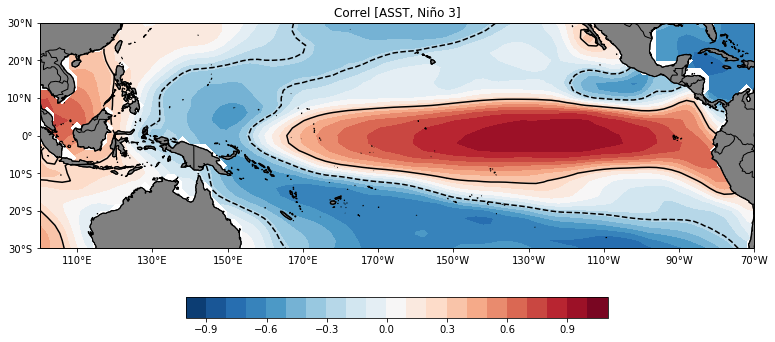

In [18]:
plt.figure(figsize=(12,5))
inter = np.arange(-1.0, 1.2, 0.1)
interc = [-1.0, 1.0]

proj  =  ccrs.PlateCarree(central_longitude=180.)
ax = plt.axes(projection=proj)
y_lats  = np.arange(-40,40,10)
x_lons  = np.arange(-70,360,20)
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                   number_format='.0f')
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
tick_fs = 16
ax.set_xticks(x_lons, minor=False, crs=proj)
ax.set_yticks(y_lats, minor=False, crs=proj)
ax.add_feature(cf.LAND,color='grey')
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.coastlines(resolution='50m',color='black')

plt.contour(lon, lat, t1_rec[0,:,:],interc,
            colors=('k',),linestyles=('--','-'),
            transform=ccrs.PlateCarree(),)


plt.contourf(lon, lat, r_rec[0,:,:], inter,
             transform=ccrs.PlateCarree(),
             cmap=plt.get_cmap('RdBu_r'))

plt.colorbar(ax=ax, shrink=0.5, orientation='horizontal')
plt.title(u'Correl [ASST, Niño 3]')

plt.tight_layout()
plt.show()

That looks colorful enough for our tastes, and we can also see the ENSO pattern clearly (which is the important thing here).

Again, there are lots of ways to estimate the number of degrees of freedom. The one we used here is just a glimpse but you should feel free to explore other methods, this is a vital topic for climate science albeit a rather ignored one.

Hope you've enjoyed this lesson!

### NOTE: No statisticians were harmed in the making of this notebook, but some might get angry with me by now.

## REFERENCES

1 - Chen, W. Y. "Fluctuations in Northern Hemisphere 700 mb height field associated with the Southern Oscillation." Monthly Weather Review 110.7 (1982): 808-823.

2 - Livezey, Robert E., and W. Y. Chen. "Statistical field significance and its determination by Monte Carlo techniques." Monthly Weather Review 111.1 (1983): 46-59.

3 - Davis, Russ E. "Predictability of sea surface temperature and sea level pressure anomalies over the North Pacific Ocean." Journal of Physical Oceanography 6.3 (1976): 249-266.

4 - Thiébaux, H. Jean, and Francis W. Zwiers. "The interpretation and estimation of effective sample size." Journal of Climate and Applied Meteorology 23.5 (1984): 800-811.

5 - Storch, Hans von, and Antonio Navarra. "Analysis of climate variability." (1999).